# Explore SDSSRM-XCS Scatter: $M_{\rm{gas}}$-$L_{\rm{X}}$ a diagnostic for scatter in other relations?

This section of the project explores potential reasons and diagnostics of galaxy cluster/group scaling relation scatter using the new SDSSRM-XCS relations constructed in this work from the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract).

Here we focus on the relationship between the hot gas mass of galaxy clusters and groups ($M_{\rm{gas}}$, or $M^{\rm{gas}}_{\\Delta}$ within an overdensity radius $R_{\Delta}$), and the X-ray luminosity of that same hot gas. The density of ICM within an aperture is set by the total containing gas mass, and as the X-ray luminosity of galaxy clusters is most strongly dependent on the square of the density (it is more complicated than this of course, there is a temperature dependence as well), these quantities should be very closely correlated.

As such, we ask the question of whether any outliers/scattered clusters in the $M_{\rm{gas}}$-$L_{\rm{X}}$ relation might be predictive of scatter in other scaling relations, and if we can use $M_{\rm{gas}}$-$L_{\rm{X}}$ relations to define a metric that describes whether the hot gas in a cluster is in a 'typical' state, or is some way unusual.

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* The

## Import Statements 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import pickle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo, lx_norm, mgas_norm, m_norm, rich_norm, tx_norm

import xga
from xga.relations.fit import scaling_relation_lira

## Setting up colour maps to add more information to data points

### Binary colour map

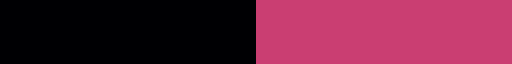

In [2]:
donor_cmap = matplotlib.colormaps['magma']
binary_cmap = LinearSegmentedColormap.from_list('binary', donor_cmap([0.0, 0.55]), N=2)
binary_cmap

## Loading data files and relations

We load the 'base' SDSSRM-XCS sample file, containing some basic information about galaxy cluster names, positions, and redshifts. We also load the SDSSRM-XCS cluster property results files from the first paper of this series.

The new SDSSRM-XCS scaling relations (constructed in the course of this work) that relate the hot gas mass and X-ray luminosity are also loaded in here - though we do not necessarily load and use _all_ of those relations. The relation data points and scatters will help to identify particular galaxy clusters to investigate, and to consider if this type of scaling relation can act as a diagnostic of likely scatter in _other_ scaling relations. We also load some relations between other properties, which we will assess with the help of the $M_{\rm{gas}}$-$L_{\rm{X}}$ relations.

### SDSSRM-XCS base sample

In [3]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,True,False
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,True,False
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,True,False
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,False,True
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,True,False
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,True,False


Calculating E(z) values for these clusters:

In [4]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

### SDSSRM-XCS $T_{\rm{X}}$ and $L_{\rm{X}}$

In [5]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_txlx.head(6)

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,Tx_2500,Tx_2500-,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lxbol_2500,Lxbol_2500-,Lxbol_2500+,Tx_500ce,Tx_500ce-,Tx_500ce+,Lx52_500ce,Lx52_500ce-,Lx52_500ce+,Lxbol_500ce,Lxbol_500ce-,Lxbol_500ce+
0,SDSSXCS-124,6.92000,0.116389,0.111642,5.310408e+44,2.494586e+42,3.193270e+42,2.039754e+45,2.082091e+43,1.712354e+43,7.08946,0.097823,0.097929,4.008461e+44,2.163312e+42,1.887667e+42,1.557705e+45,1.278003e+43,1.166420e+43,6.78098,0.134306,0.158223,3.684827e+44,2.702225e+42,2.572964e+42,1.401501e+45,1.425781e+43,1.280567e+43
1,SDSSXCS-2789,4.54033,0.073600,0.074023,1.029575e+44,5.149604e+41,6.858712e+41,3.213527e+44,3.914562e+42,3.124017e+42,4.44237,0.057404,0.057774,7.125319e+43,4.164749e+41,3.793543e+41,2.201238e+44,1.767406e+42,1.642524e+42,4.65452,0.108600,0.113677,6.943669e+43,6.482835e+41,5.773788e+41,2.192642e+44,2.960496e+42,2.652251e+42
2,SDSSXCS-290,5.31681,0.297854,0.336308,2.856695e+44,5.917234e+42,7.322989e+42,9.632533e+44,4.005991e+43,3.207763e+43,5.41431,0.259989,0.309605,2.033267e+44,4.662931e+42,4.169953e+42,6.920658e+44,2.211700e+43,1.983518e+43,5.44819,0.407899,0.486340,1.972104e+44,6.434636e+42,6.092122e+42,6.734043e+44,3.038773e+43,2.687861e+43
3,SDSSXCS-1018,3.90154,0.143544,0.151498,8.044819e+43,1.441322e+42,9.241468e+41,2.335851e+44,6.385493e+42,4.924304e+42,4.09555,0.108381,0.115430,6.395952e+43,8.467201e+41,7.602523e+41,1.899850e+44,3.436098e+42,3.542190e+42,3.93098,0.207281,0.230478,5.048987e+43,1.253282e+42,1.066663e+42,1.471118e+44,5.740520e+42,4.871391e+42
4,SDSSXCS-134,6.72622,0.116523,0.116565,4.811899e+44,2.458557e+42,3.050440e+42,1.825296e+45,2.068757e+43,1.639058e+43,7.04643,0.104430,0.104760,3.813160e+44,2.170963e+42,1.872005e+42,1.479760e+45,1.263153e+43,1.208755e+43,6.37686,0.135837,0.153820,3.447715e+44,2.713877e+42,2.497416e+42,1.273855e+45,1.415497e+43,1.228583e+43
5,SDSSXCS-119,4.93456,0.400268,0.456173,2.049789e+44,5.182032e+42,6.885075e+42,6.654626e+44,4.141700e+43,3.282061e+43,5.41255,0.397709,0.448294,1.239172e+44,3.785057e+42,3.735144e+42,4.215892e+44,2.155310e+43,1.870703e+43,4.91222,0.432241,0.503558,1.821676e+44,5.522211e+42,5.714386e+42,5.900648e+44,3.822404e+43,2.772960e+43


### SDSSRM-XCS masses

In [6]:
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_mass.head(6)

,name,Mhy500,Mhy500-,Mhy500+,Mg500,Mg500-,Mg500+,Mhy2500,Mhy2500-,Mhy2500+,Mg2500,Mg2500-,Mg2500+,Mhy500_wraderr,Mhy500_wraderr-,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,7.634491,1.286289,1.029318,0.869914,0.002841,0.005951,2.621329,0.112240,0.137975,0.321744,0.000722,0.000734,7.635562,1.285474,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,7.820374,1.259755,1.447212,0.218603,0.002491,0.002496,1.602926,0.101929,0.109311,0.097414,0.000324,0.000329,7.823912,1.268244,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,2.961604,0.369827,0.382523,0.427969,0.002132,0.002098,1.467429,0.175603,0.290465,0.134154,0.000759,0.000773,2.959792,0.390293,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,5.067958,1.015270,0.969362,0.210208,0.001929,0.001917,1.128892,0.103503,0.149913,0.084371,0.000350,0.000359,5.072697,1.030805,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,6.802619,0.782566,0.772819,0.767290,0.002149,0.002170,3.043225,0.113304,0.110341,0.313945,0.000359,0.000367,6.803511,0.788996,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
5,SDSSXCS-119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining tables

In [7]:
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

### $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$

In [8]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas2500_lxbol_2500.xgarel', 'rb') as scalo:
    mgas2500_lxbol_2500 = pickle.load(scalo)

### $M^{\rm{gas}}_{2500}$-$L^{\rm{0.5-2.0}}_{\rm{X,2500}}$

In [9]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas2500_lx52_2500.xgarel', 'rb') as scalo:
    mgas2500_lx52_2500 = pickle.load(scalo)

### $M^{\rm{gas}}_{500}$-$L^{\rm{bol}}_{\rm{X,500}}$

In [10]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas500_lxbol_500.xgarel', 'rb') as scalo:
    mgas500_lxbol_500 = pickle.load(scalo)

### $M^{\rm{gas}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$

In [11]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mgas-lx/turner2025_mgas500_lxbol_500ce.xgarel', 'rb') as scalo:
    mgas500_lxbol_500ce = pickle.load(scalo)

## Deviations from the 'typical' state of the hot ICM

Here we will re-examine the new SDSSRM-XCS $M_{\rm{gas}}$ and $L_{\rm{X}}$ constraints, with a particular focus on the data points furthest away from the scaling relation line (what we will describe as the 'typical' state of the ICM, though with a whole host of caveats ranging from statistical selection functions to the slightly circular nature of this process). 

The hypothesis here is that more extreme examples of cool-core and unrelaxed clusters will make themselves known by significant deviations from the trend of the overall sample (which was selected from optical cluster catalogs, rather than from a larger X-ray sample, and should be somewhat free of the common selection effects of preferentially selecting bright cool cores - though this argument is slightly foiled by the fact that we were only able to examine those optically selected clusters that had an XMM observation). 

If our hypothesis is correct, we will be able to define a simple metric that side-steps the cool-core/non-cool-core labels (though of course still contains much of the same information) and instead can be used to ask: 'how strongly affected by its own astrophysics is a particular cluster?' We hope that the quantities used will be simple enough to measure that it will be feasible to do this at a large scale, in support of LSST-DESC cluster cosmology for instance, as more focus is now being put on the effect of the baryon content of clusters on things like weak-lensing measurements.

### Reminding ourselves of the $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ relation

We show a visualisation of the $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ relation, as it has the lowest intrinsic scatter of the six different $M_{\rm{gas}}$-$L_{\rm{X}}$ relations we constructed. As such, we hope that extreme outliers will be more obvious. Initially focusing on the gas in the core region of the cluster is also interesting because many of the signatures of astrophysical processes in clusters can be found there.

A first examination of this scaling relation led us to notice a clump of data points (in red) that lay quite far underneath the fit line, while exhibiting small uncertainties - their X-ray luminosity was quite high compared to their hot gas mass, at least relative to the overall behaviours of this sample. 

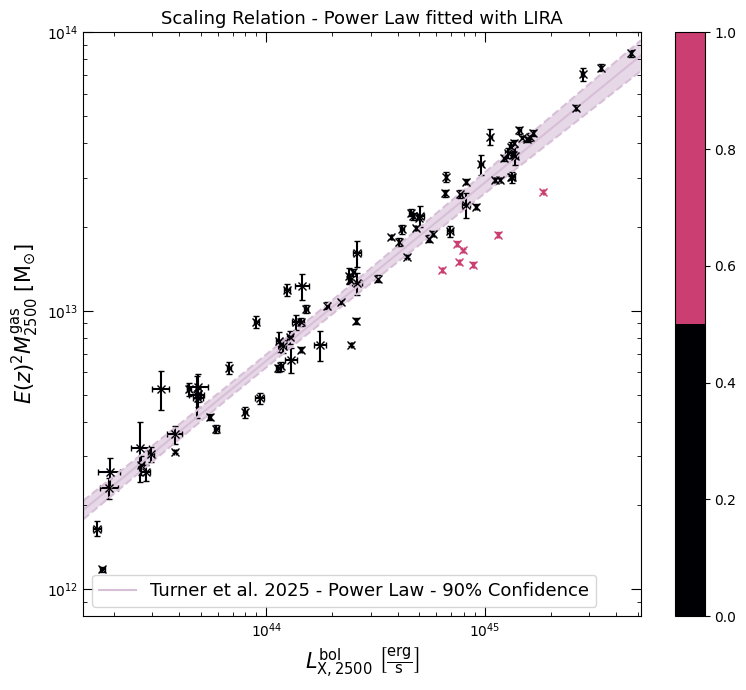

In [12]:
clump_names = ['SDSSXCS-11331', 'SDSSXCS-7783', 'SDSSXCS-572', 'SDSSXCS-9803', 'SDSSXCS-1628', 'SDSSXCS-2288', 'SDSSXCS-2032']
point_colour = np.zeros(len(mgas2500_lxbol_2500.x_data[:, 0]))
point_colour[np.where(np.isin(mgas2500_lxbol_2500.point_names, clump_names))[0]] = 1

mgas2500_lxbol_2500._third_dim_info = point_colour
mgas2500_lxbol_2500._third_dim_name = ''
mgas2500_lxbol_2500.view(figsize=(8, 7), y_lims=Quantity([0.8e+12, 1e+14], 'Msun'), label_points=False, 
                         point_label_offset=(0.01, 0.001), third_dim_cmap=binary_cmap)

We believed that the most likely physical explanation for this 'clump' of data points were galaxy clusters with abnormally low temperatures relative to their density in the $R_{2500}$ region - the increased radiative cooling would then be the cause of the higher than expected luminosity. The other possibility we considered was that the metallicity of the gas was abnormally high, and thus more emission line radiative cooling was occuring than is usual. In other words, we suspect that the gas in the core of these clusters will have very low central entropy.

This initial assessment is supported by how these particular clusters look in the XMM data we used to constrain temperature, density, and mass profiles in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract) - though visual inspection is not a fool-proof scientific method for identifying galaxy clusters with low central entropy, their appearance is highly characteristic of such systems. They are all very similar in appearance:

#### SDSSXCS-11331 and SDSSXCS-7783

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-11331.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-7783.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

#### SDSSXCS-572 and SDSSXCS-9803

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-572.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-9803.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

#### SDSSXCS-1628, SDSSXCS-2288, and SDSSXCS-2032 

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-1628.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-2288.png?raw=true" width = "500" height = "500">  </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-2032.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

We identify the common names of these clusters to enable us to search the Archive of Chandra Cluster Entropy Profile Tables (ACCEPT) - currently the largest and most well-regarded set of ICM-entropy-related measurements. The ACCEPT analyses were performed using Chandra data, which, as Chandra's angular resolution is much better than XMM's, means it is better placed to constrain core entropy than the temperature and density profiles we measured in our first paper.

The first four clusters are **in** ACCEPT, and the last three are not: 

* SDSSXCS-572 - **Abell 383**
* SDSSXCS-9803 - **ZwCl 0857.9+2107**
* SDSSXCS-1628 - **Abell 1068**
* SDSSXCS-2288 - **MS 1455.0+2232**
----------

* SDSSXCS-11331 - **MCXC J0106.8+0103**
* SDSSXCS-7783 - **Abell 291**
* SDSSXCS-2032 - Doesn't really have a more common name, it wasn't in MCXC, but was found by ACT (and obviously by redMaPPer and XCS).

----------

The clusters with ACCEPT counterparts all have very low central entropies - ZwCl 0857.9+2107 has the highest $K_{0}$ value at 24.25 keV cm$^{2}$ (still **very** low), and the other three all have $K_{0}$~10 keV cm$^{2}$. This is consistent with our hypothesis, and means that we may now have a new metric for identifying low central entropy clusters using relatively-simple-to-acquire X-ray properties.

## Metric for deviation from the 'typical' $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$

To formalise this insight a little more, we define the following metric:

$\delta_{\rm{GML}} = \dfrac{M^{\rm{gas,meas}}_{2500} - M^{\rm{gas,pred}}_{2500}}{M^{\rm{gas,pred}}_{2500}}$,

which is a characterisation of how scattered an individual cluster is from the 'typical' (here defined as the scaling relation that we have measured using this sample, though really more careful work including selection functions would be needed to this properly) relationship between gas mass and X-ray luminosity, as a fraction of what the 'typical' gas mass would be based on measured luminosity (this is to put different mass systems on an even footing).

We hypothesise that the extremes of the $\delta_{\rm{GML}}$ distribution should be populated by very strong cool core/highly disturbed clusters respectively - this may be a useful numerical metric for characterising those types of clusters, rather than the standard labels. The information required for this metric also requires much lower data quality than directly measuring a temperature profile, and may even be accessible for eRASS clusters.

In [65]:
sort_rel_names = np.argsort(sdssxcs_samp['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_samp['name'].values, mgas2500_lxbol_2500.point_names, sorter=sort_rel_names)]

# Reads out gas masses in two apertures, in the right order!
z = sdssxcs_samp.loc[pnt_samp_ind, 'z'].values
mgas2500 = Quantity(sdssxcs_samp.loc[pnt_samp_ind, 'Mg2500_wraderr'].values*1e+14, 'Msun')

# Predict gas masses from each cluster's measured luminosity from the overall population trend represented by the
#  scaling relation
pred_mgas2500_lxbol = mgas2500_lxbol_2500.predict(mgas2500_lxbol_2500.x_data[:, 0], x_errors=mgas2500_lxbol_2500.x_data[:, 1], 
                                                  redshift=z, cosmo=xcs_cosmo)

# The deviation metric from Lxbol predictions
delta_gml_lxbol = ((mgas2500 - pred_mgas2500_lxbol[:, 0]) / pred_mgas2500_lxbol[:, 0])

# We also calculate the same values based on the 0.5-2.0 keV gasmass-Lx relation, and reselect the data points from the 
#  overall sample file in an overabundance of caution
sort_rel_names = np.argsort(sdssxcs_samp['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_samp['name'].values, mgas2500_lx52_2500.point_names, sorter=sort_rel_names)]

# Reads out gas masses in two apertures, in the right order!
z = sdssxcs_samp.loc[pnt_samp_ind, 'z'].values
mgas2500 = Quantity(sdssxcs_samp.loc[pnt_samp_ind, 'Mg2500_wraderr'].values*1e+14, 'Msun')

pred_mgas2500_lx52 = mgas2500_lx52_2500.predict(mgas2500_lx52_2500.x_data[:, 0], x_errors=mgas2500_lx52_2500.x_data[:, 1], 
                                                redshift=z, cosmo=xcs_cosmo)
delta_gml_lx52 = ((mgas2500 - pred_mgas2500_lx52[:, 0]) / pred_mgas2500_lx52[:, 0])

### Visualising the deviation distributions for the $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ and $M^{\rm{gas}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ relations

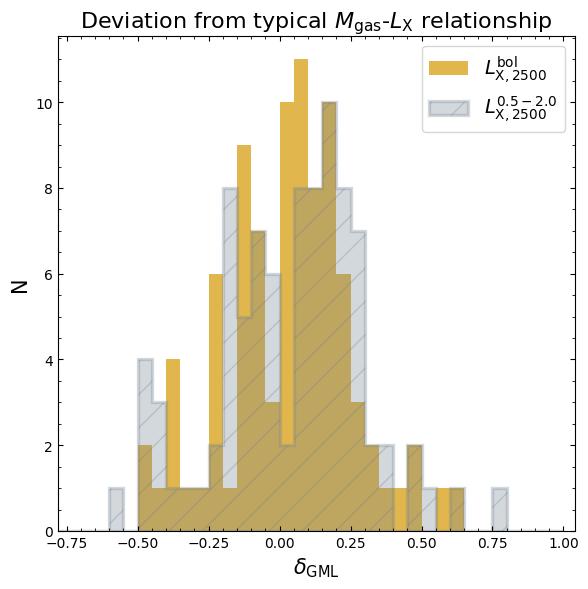

In [117]:
min_delta_gml = min(delta_gml_lxbol.min(), delta_gml_lx52.min())
max_delta_gml = max(delta_gml_lxbol.max(), delta_gml_lx52.max())

# print("Lowest value is {}\n".format(min_delta_gml.round(4)), 
#       "Highest value is {}".format(max_delta_gml.round(4)), sep='')

# Setting up the bounds for the distribution histogram, size of 0.05
bin_bnds = np.linspace(-1, 1, 41)

plt.figure(figsize=(6, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Distribution using the mgas-Lxbol relation
plt.hist(delta_gml_lxbol, bins=bin_bnds, color='goldenrod', histtype="stepfilled", alpha=0.8, 
         label=r'$L^{\rm{bol}}_{\rm{X,2500}}$')
# Distribution using the mgas-Lx52 relation
plt.hist(delta_gml_lx52, bins=bin_bnds, color='slategrey', hatch='/', histtype="stepfilled", edgecolor='slategrey', alpha=0.3, lw=2.4, 
         label=r'$L^{\rm{0.5-2.0}}_{\rm{X,2500}}$')

# plt.axvline(np.median(plotto), color='red')
# plt.axvline(np.percentile(plotto, 84.1), color='red', linestyle='dashed')
# plt.axvline(np.percentile(plotto, 15.9), color='red', linestyle='dashed')

# Shrink the x-bounds of the histogram a little, to fit the actual data we're plotting
plt.xlim((np.floor(min_delta_gml*10)/10)*1.3, 
         (np.ceil(max_delta_gml*10)/10)*1.3)

plt.ylabel('N', fontsize=15)
plt.xlabel(r'$\delta_{\rm{GML}}$', fontsize=15)

plt.title(r"Deviation from typical $M_{\rm{gas}}$-$L_{\rm{X}}$ relationship", fontsize=16)

plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("../../outputs/figures/exploring_scatter/mgas-lx_dev_dist.pdf")
plt.show()

### Where are those low central entropy clusters from earlier?

We fetch the $\delta_{\rm{GML}}$ values calculated from the bolometric luminosity for the clump of galaxy clusters well below the relation that we discussed earlier. Looking at the values we see that, not unsurprisingly given how $\delta_{\rm{GML}}$ is defined, they are all at the extreme edge of the distribution, with very low $\delta_{\rm{GML}}$ values:

In [131]:
delta_gml_lxbol[np.where(np.isin(mgas2500_lxbol_2500.point_names, clump_names))[0]].value
{n: float(delta_gml_lxbol[np.where(mgas2500_lxbol_2500.point_names == n)[0][0]].value.round(4)) for n in clump_names}

{'SDSSXCS-11331': -0.4519,
 'SDSSXCS-7783': -0.3535,
 'SDSSXCS-572': -0.3391,
 'SDSSXCS-9803': -0.4044,
 'SDSSXCS-1628': -0.3837,
 'SDSSXCS-2288': -0.3743,
 'SDSSXCS-2032': -0.2695}

### Are there other similar clusters?

If we preliminarily define that clusters with $\delta^{\rm{bol}}_{\rm{GML,2500}}<-0.25$ (specifically for the bolometric luminosity version) have ultra-cool-cores/very low central entropy, and apply this to the distribution above do we select any **other** clusters (remember that we just visually selected the low central entropy clusters earlier on)?

In [144]:
oth_low_delta_gmlbol = mgas2500_lxbol_2500.point_names[((delta_gml_lxbol < -0.25) &  
                                                        (~np.isin(mgas2500_lxbol_2500.point_names, clump_names)))]

{n: float(delta_gml_lxbol[np.where(mgas2500_lxbol_2500.point_names == n)[0][0]].value.round(4)) for n in oth_low_delta_gmlbol}

{'SDSSXCS-2836': -0.3564, 'SDSSXCS-5159': -0.4615}

#### Identifying common names

We search NED to see if these galaxy clusters have more commonly used names (if they were in an Abell catalog for instance) - neither cluster seems to be particularly famous, but have been present in some influential cluster catalogs. 

* SDSSXCS-2836 - **MCXC J1442.3+2218/ZwCl 1439.5+2225/RBS 1419**
* SDSSXCS-5159 - Doesn't really have a more common name

We also make sure to search the ACCEPT dataset, and find that neither of these clusters were processed as part of that work.

#### Visualising SDSSXCS-2836 and SDSSXCS-5159

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-2836.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-5159.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

### What are the clusters on the extreme upper end of the $\delta_{\rm{GML}}$ distribution like?

We sort the clusters by descending $\delta_{\rm{GML}}$ - we hypothesise that the clusters with high $\delta_{\rm{GML}}$ values will have lower than typical density compared to temperature due to astrophysical processes that heat the gas in the core/whole volume of the cluster:

In [176]:
sort_names = mgas2500_lxbol_2500.point_names[np.argsort(delta_gml_lxbol)[::-1]]
sort_names

array(['SDSSXCS-2282', 'SDSSXCS-23', 'SDSSXCS-325', 'SDSSXCS-1131',
       'SDSSXCS-155', 'SDSSXCS-457', 'SDSSXCS-15', 'SDSSXCS-765',
       'SDSSXCS-309', 'SDSSXCS-6955', 'SDSSXCS-31', 'SDSSXCS-71',
       'SDSSXCS-209', 'SDSSXCS-944', 'SDSSXCS-586', 'SDSSXCS-9313',
       'SDSSXCS-147', 'SDSSXCS-123', 'SDSSXCS-487', 'SDSSXCS-890',
       'SDSSXCS-2', 'SDSSXCS-7432', 'SDSSXCS-75', 'SDSSXCS-110',
       'SDSSXCS-11881', 'SDSSXCS-314', 'SDSSXCS-1645', 'SDSSXCS-7416',
       'SDSSXCS-55', 'SDSSXCS-13', 'SDSSXCS-16286', 'SDSSXCS-907',
       'SDSSXCS-34', 'SDSSXCS-134', 'SDSSXCS-236', 'SDSSXCS-298',
       'SDSSXCS-41', 'SDSSXCS-51', 'SDSSXCS-3312', 'SDSSXCS-29',
       'SDSSXCS-395', 'SDSSXCS-68', 'SDSSXCS-124', 'SDSSXCS-3672',
       'SDSSXCS-19', 'SDSSXCS-226', 'SDSSXCS-1018', 'SDSSXCS-6',
       'SDSSXCS-2347', 'SDSSXCS-9', 'SDSSXCS-189', 'SDSSXCS-575',
       'SDSSXCS-65', 'SDSSXCS-64824', 'SDSSXCS-5830', 'SDSSXCS-10401',
       'SDSSXCS-165', 'SDSSXCS-2789', 'SDSSXCS-22', 'SDSSXCS-8

We select the clusters with the top nine highest $\delta_{\rm{GML}}$ values, and examine their XMM count-rate maps:

#### SDSSXCS-2282, SDSSXCS-23, and SDSSXCS-325 

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-2282.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-23.png?raw=true" width = "500" height = "500">  </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-325.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

#### SDSSXCS-1131, SDSSXCS-155, and SDSSXCS-457

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-1131.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-155.png?raw=true" width = "500" height = "500">  </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-457.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

#### SDSSXCS-15, SDSSXCS-765, and SDSSXCS-309

<table><tr>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-15.png?raw=true" width = "500" height = "500"> </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-765.png?raw=true" width = "500" height = "500">  </td>
<td> <img src = "https://github.com/DavidT3/XCS-Mass-Paper-I-Analysis/blob/master/outputs/cluster_visualisations/sdssrm-xcs/SDSSXCS-309.png?raw=true" width = "500" height = "500">  </td>
</tr></table>

We note that the X-ray appearances of these galaxy clusters are in some cases quite different from the low-$\delta_{\rm{GML}}$ clusters earlier. In general the surface brightness distributions are much less peaked, and the clusters look more like a 'puffed up' ball of gas (quite characteristic of disturbed clusters). Some of the systems are appear to be currently interacting with another cluster (or soon will be; with the possibility of projection ignored for the moment). 

Unfortunately none of these clusters is part of the ACCEPT I sample, so we cannot use them to examine the central entropy of these systems. The immediate utility of this higher extreme of the $\delta_{\rm{GML}}$ distribution is currently less clear to us than the lower extreme, but could be a hint of high-temperature shock-regions in these galaxy clusters - future work will examine this idea more carefully.

## 

In [ ]:
stop

In [ ]:
np.median(plotto)

In [ ]:
np.percentile(plotto, 84.1) - np.median(plotto)

In [ ]:
np.median(plotto) - np.percentile(plotto, (50-34.1))

SDSSXCS-5159 is a false entry here I think - still a bit flared to my chagrin

In [ ]:
sdssxcs_base[sdssxcs_base['name'].isin(['SDSSXCS-2836', 'SDSSXCS-5159'])]

In [ ]:
mgas2500_lxbol_2500.point_names[np.argwhere(plotto > 0.25)]

In [ ]:
ns = mgas2500_lxbol_2500.point_names[np.argwhere((plotto > -0.3) & (plotto < -0.2))]
ns

In [ ]:
sdssxcs_base[sdssxcs_base['name'].isin(ns.flatten())]

In [ ]:
cc_half = np.argwhere(plotto < -0.1).flatten()
ncc_half = np.argwhere(plotto >= -0.1).flatten()

In [ ]:
slim_chos = np.argwhere((plotto > -0.2) & (plotto < 0.2)).flatten()
slim_chos

In [ ]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-tx/turner2025_mtot2500_tx2500.xgarel', 'rb') as scalo:
    mtot2500_tx2500 = pickle.load(scalo)

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_tx2500.pars[0][0], e=mtot2500_tx2500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_tx2500.pars[1][0], e=mtot2500_tx2500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_tx2500.scatter_par[0], e=mtot2500_tx2500.scatter_par[1]))

In [ ]:
mtot2500_tx2500.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
sel_mtot2500 = mtot2500_tx2500.y_data[slim_chos, :]
sel_mtot2500 = np.concatenate((sel_mtot2500, sel_mtot2500[:, 1, None]), axis=1)
sel_tx2500 = mtot2500_tx2500.x_data[slim_chos, :]
sel_tx2500 = np.concatenate((sel_tx2500, sel_tx2500[:, 1, None]), axis=1)

mtot2500_tx2500_sub = scaling_relation_lira(sel_mtot2500[:, 0], sel_mtot2500[:, 1:], sel_tx2500[:, 0], sel_tx2500[:, 1:], 
                                            m_norm, tx_norm, y_name=r"$E(z)M^{\rm{tot}}_{2500}$", x_name=r"$T_{\rm{X,2500}}$", 
                                            dim_hubb_ind=1, point_names=sdssxcs_samp['name'].values)
mtot2500_tx2500_sub.model_colour = 'navajowhite'
mtot2500_tx2500_sub.author = 'Turner et al.'
mtot2500_tx2500_sub.year = 2025
mtot2500_tx2500_sub.name = r'Turner et al. $E(z)M^{\rm{tot}}_{2500}$-$T_{\rm{X,2500}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_tx2500_sub.pars[0][0], e=mtot2500_tx2500_sub.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_tx2500_sub.pars[1][0], e=mtot2500_tx2500_sub.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_tx2500_sub.scatter_par[0], e=mtot2500_tx2500_sub.scatter_par[1]))

In [ ]:
mtot2500_tx2500_sub.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-richness/turner2025_mtot2500_richness.xgarel', 'rb') as scalo:
    mtot2500_rich = pickle.load(scalo)

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich.pars[0][0], e=mtot2500_rich.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich.pars[1][0], e=mtot2500_rich.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_rich.scatter_par[0], e=mtot2500_rich.scatter_par[1]))

In [ ]:
mtot2500_rich.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
sel_mtot2500 = mtot2500_rich.y_data[slim_chos, :]
sel_mtot2500 = np.concatenate((sel_mtot2500, sel_mtot2500[:, 1, None]), axis=1)
sel_rich = mtot2500_rich.x_data[slim_chos, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot2500_rich_sub = scaling_relation_lira(sel_mtot2500[:, 0], sel_mtot2500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                          m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                          point_names=sdssxcs_samp['name'].values)
mtot2500_rich_sub.model_colour = 'dodgerblue'
mtot2500_rich_sub.author = 'Turner et al.'
mtot2500_rich_sub.year = 2025
mtot2500_rich_sub.name = r'Turner et al. Slim $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_sub.pars[0][0], e=mtot2500_rich_sub.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_sub.pars[1][0], e=mtot2500_rich_sub.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_rich_sub.scatter_par[0], e=mtot2500_rich_sub.scatter_par[1]))

In [ ]:
mtot2500_rich_sub.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
sel_mtot2500 = mtot2500_rich.y_data[cc_half, :]
sel_mtot2500 = np.concatenate((sel_mtot2500, sel_mtot2500[:, 1, None]), axis=1)
sel_rich = mtot2500_rich.x_data[cc_half, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot2500_rich_cchalf = scaling_relation_lira(sel_mtot2500[:, 0], sel_mtot2500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                             m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                             point_names=sdssxcs_samp['name'].values)
mtot2500_rich_cchalf.model_colour = 'dodgerblue'
mtot2500_rich_cchalf.author = 'Turner et al.'
mtot2500_rich_cchalf.year = 2025
mtot2500_rich_cchalf.name = r'Turner et al. CC Half $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_cchalf.pars[0][0], e=mtot2500_rich_cchalf.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_cchalf.pars[1][0], e=mtot2500_rich_cchalf.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_rich_cchalf.scatter_par[0], e=mtot2500_rich_cchalf.scatter_par[1]))

In [ ]:
mtot2500_rich_cchalf.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
sel_mtot2500 = mtot2500_rich.y_data[ncc_half, :]
sel_mtot2500 = np.concatenate((sel_mtot2500, sel_mtot2500[:, 1, None]), axis=1)
sel_rich = mtot2500_rich.x_data[ncc_half, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot2500_rich_ncchalf = scaling_relation_lira(sel_mtot2500[:, 0], sel_mtot2500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                              m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                              point_names=sdssxcs_samp['name'].values)
mtot2500_rich_ncchalf.model_colour = 'dodgerblue'
mtot2500_rich_ncchalf.author = 'Turner et al.'
mtot2500_rich_ncchalf.year = 2025
mtot2500_rich_ncchalf.name = r'Turner et al. NCC Half $M^{\rm{tot}}_{2500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_ncchalf.pars[0][0], e=mtot2500_rich_ncchalf.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_rich_ncchalf.pars[1][0], e=mtot2500_rich_ncchalf.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_rich_ncchalf.scatter_par[0], e=mtot2500_rich_ncchalf.scatter_par[1]))

In [ ]:
mtot2500_rich_ncchalf.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
(mtot2500_rich_sub + mtot2500_rich_cchalf + mtot2500_rich_ncchalf).view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

In [ ]:
(mtot2500_rich + mtot2500_rich_sub + mtot2500_rich_cchalf + mtot2500_rich_ncchalf).view_corner()

### Richess R500 mass

### OG

In [ ]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-richness/turner2025_mtot500_richness.xgarel', 'rb') as scalo:
    mtot500_rich = pickle.load(scalo)

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich.pars[0][0], e=mtot500_rich.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich.pars[1][0], e=mtot500_rich.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich.scatter_par[0], e=mtot500_rich.scatter_par[1]))

In [ ]:
mtot500_rich.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

### Refit but only clusters with R2500 info

In [ ]:
sort_rel_names = np.argsort(sdssxcs_samp['name'].values)
pnt_samp_ind = sort_rel_names[np.searchsorted(sdssxcs_samp['name'].values, mgas2500_lxbol_2500.point_names, sorter=sort_rel_names)]

# Reads out gas masses in two apertures, in the right order!
z = sdssxcs_samp.loc[pnt_samp_ind, 'z'].values
mgas2500 = Quantity(sdssxcs_samp.loc[pnt_samp_ind, 'Mg2500_wraderr'].values*1e+14, 'Msun')

In [ ]:
# Setting up property variables in astropy quantity objects
sdssxcs_samp_wR2500 = sdssxcs_samp[sdssxcs_samp['name'].isin(mgas2500_lxbol_2500.point_names)]

mtot500 = Quantity(sdssxcs_samp_wR2500[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')
rich = Quantity(sdssxcs_samp_wR2500[['richness', 'richness_err','richness_err']].values, '')

mtot500_rich_wr2500 = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], rich[:, 0], rich[:, 1:], m_norm, rich_norm, 
                                     y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                     point_names=sdssxcs_samp_wR2500['name'].values)
mtot500_rich_wr2500.model_colour = 'goldenrod'
mtot500_rich_wr2500.author = 'Turner et al.'
mtot500_rich_wr2500.year = 2025
mtot500_rich_wr2500.name = r'Turner et al. $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500.pars[0][0], e=mtot500_rich_wr2500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500.pars[1][0], e=mtot500_rich_wr2500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich_wr2500.scatter_par[0], e=mtot500_rich_wr2500.scatter_par[1]))

In [ ]:
mtot500_rich_wr2500.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

### 'Slim' selection

In [ ]:
sel_mtot500 = mtot500_rich_wr2500.y_data[slim_chos, :]
sel_mtot500 = np.concatenate((sel_mtot500, sel_mtot500[:, 1, None]), axis=1)
sel_rich = mtot500_rich_wr2500.x_data[slim_chos, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot500_rich_wr2500_sub = scaling_relation_lira(sel_mtot500[:, 0], sel_mtot500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                          m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                          point_names=mtot500_rich_wr2500.point_names[slim_chos])
mtot500_rich_wr2500_sub.model_colour = 'goldenrod'
mtot500_rich_wr2500_sub.author = 'Turner et al.'
mtot500_rich_wr2500_sub.year = 2025
mtot500_rich_wr2500_sub.name = r'Turner et al. Slim $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_sub.pars[0][0], e=mtot500_rich_wr2500_sub.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_sub.pars[1][0], e=mtot500_rich_wr2500_sub.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich_wr2500_sub.scatter_par[0], e=mtot500_rich_wr2500_sub.scatter_par[1]))

In [ ]:
mtot500_rich_wr2500.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

### 'CC Half' Selection

In [ ]:
sel_mtot500 = mtot500_rich_wr2500.y_data[cc_half, :]
sel_mtot500 = np.concatenate((sel_mtot500, sel_mtot500[:, 1, None]), axis=1)
sel_rich = mtot500_rich_wr2500.x_data[cc_half, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot500_rich_wr2500_cchalf = scaling_relation_lira(sel_mtot500[:, 0], sel_mtot500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                          m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                          point_names=mtot500_rich_wr2500.point_names[cc_half])
mtot500_rich_wr2500_cchalf.model_colour = 'goldenrod'
mtot500_rich_wr2500_cchalf.author = 'Turner et al.'
mtot500_rich_wr2500_cchalf.year = 2025
mtot500_rich_wr2500_cchalf.name = r'Turner et al. CC Half $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_cchalf.pars[0][0], e=mtot500_rich_wr2500_cchalf.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_cchalf.pars[1][0], e=mtot500_rich_wr2500_cchalf.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich_wr2500_cchalf.scatter_par[0], e=mtot500_rich_wr2500_cchalf.scatter_par[1]))

In [ ]:
mtot500_rich_wr2500_cchalf.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'), label_points=True)

In [ ]:
mtot500_rich_wr2500_cchalf.point_names

### 'NCC Half' Selection

In [ ]:
sel_mtot500 = mtot500_rich_wr2500.y_data[ncc_half, :]
sel_mtot500 = np.concatenate((sel_mtot500, sel_mtot500[:, 1, None]), axis=1)
sel_rich = mtot500_rich_wr2500.x_data[ncc_half, :]
sel_rich = np.concatenate((sel_rich, sel_rich[:, 1, None]), axis=1)

mtot500_rich_wr2500_ncchalf = scaling_relation_lira(sel_mtot500[:, 0], sel_mtot500[:, 1:], sel_rich[:, 0], sel_rich[:, 1:], 
                                          m_norm, rich_norm, y_name=r"$M^{\rm{tot}}_{500}$", x_name=r"$\lambda_{\rm{RM}}$", 
                                          point_names=mtot500_rich_wr2500.point_names[ncc_half])
mtot500_rich_wr2500_ncchalf.model_colour = 'goldenrod'
mtot500_rich_wr2500_ncchalf.author = 'Turner et al.'
mtot500_rich_wr2500_ncchalf.year = 2025
mtot500_rich_wr2500_ncchalf.name = r'Turner et al. NCC Half $M^{\rm{tot}}_{500}$-$\lambda_{\rm{RM}}$'

In [ ]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_ncchalf.pars[0][0], e=mtot500_rich_wr2500_ncchalf.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_rich_wr2500_ncchalf.pars[1][0], e=mtot500_rich_wr2500_ncchalf.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_rich_wr2500_ncchalf.scatter_par[0], e=mtot500_rich_wr2500_ncchalf.scatter_par[1]))

In [ ]:
mtot500_rich_wr2500_ncchalf.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

In [ ]:
(mtot500_rich_wr2500 + mtot500_rich_wr2500_sub + mtot500_rich_wr2500_cchalf + mtot500_rich_wr2500_ncchalf).view_corner()

In [ ]:
(mtot500_rich_wr2500_cchalf + mtot500_rich_wr2500_ncchalf).view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 4e+15], 'Msun'))

Mark helped me get my head around this - I couldn't understand this as a physical effect, couldn't make that make sense, why would cool-cores have an almost flat relation of mass to richness? - Mark pointed out that the dynamic range in richness is actually pretty different, so it was something super basic in the end! The relations can't be compared as they are, and there is no physical meaning 

In [ ]:
mtot